In [1]:
import gym
import gym.wrappers
import numpy as np
import logging
import joblib
import matplotlib.pylab as pl
import threading
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

In [2]:
gym.logger.setLevel(logging.ERROR)
env = gym.make("LunarLander-v2")
env = gym.wrappers.Monitor(env, "lunarlander-res")
monitor_mode = True
n_actions = env.action_space.n

print("n_actions=%i" % (n_actions))

n_actions=4


In [3]:
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(128,128),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions,range(n_actions));

/home/shmuma/sfw/anaconda/envs/pract_rl/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [4]:
def generate_session(t_max=10000):
    if monitor_mode:
        global env
        e = env
    else:
        loc_data = threading.local()
        if not hasattr(loc_data, "env"):
            loc_data.env = gym.make("LunarLander-v2")
        e = loc_data.env
        
    states, actions = [], []
    total_reward = 0
    s = e.reset()
    
    for _ in range(t_max):
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(n_actions, p=probs)
        new_s, r, done, _ = e.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
    
    return states, actions, total_reward

In [5]:
n_jobs = 4
n_samples = 250
percentile = 50
rewards = []
thresholds = []
finetune_mode = False

In [11]:
for i in range(100):
    # it's essential to create new pool of workers every time
    #%time 
    if monitor_mode:
        sessions = [generate_session() for _ in range(n_samples)]
    else:
        sessions = joblib.Parallel(n_jobs)(joblib.delayed(generate_session)() for _ in range(n_samples))
    batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions))

    threshold = np.percentile(batch_rewards, percentile)
    elite_states = batch_states[batch_rewards > threshold]
    elite_actions = batch_actions[batch_rewards > threshold]

    if not elite_states.size:
        print("%d: no elite sessions, try again" % i)
        continue

    elite_states, elite_actions = map(np.concatenate, [elite_states, elite_actions])

    agent.fit(elite_states, elite_actions)
    print("%d: mean reward = %.5f (max: %f)\tthreshold = %.1f" % (
        i, np.mean(batch_rewards), np.max(batch_rewards), threshold))
    thresholds.append(threshold)
    rewards.append(np.mean(batch_rewards))
    
    if not finetune_mode and np.mean(batch_rewards) > -50:
        finetune_mode = True
        percentile = 75
        n_samples = 500
        print("Finetune mode activated")

0: mean reward = 101.11942 (max: 258.138200)	threshold = 192.0
Finetune mode activated
1: mean reward = 99.40790 (max: 254.881629)	threshold = 207.6
2: mean reward = 96.11661 (max: 256.978032)	threshold = 202.7
3: mean reward = 90.40040 (max: 256.495795)	threshold = 205.6
4: mean reward = 101.07540 (max: 260.266949)	threshold = 199.6
5: mean reward = 107.78447 (max: 263.975964)	threshold = 208.3
6: mean reward = 104.87439 (max: 261.281979)	threshold = 202.0
7: mean reward = 105.33769 (max: 260.266646)	threshold = 205.7
8: mean reward = 106.34916 (max: 257.899091)	threshold = 204.5
9: mean reward = 104.22113 (max: 260.098742)	threshold = 204.3
10: mean reward = 108.19767 (max: 257.154779)	threshold = 208.1
11: mean reward = 115.93899 (max: 257.913343)	threshold = 205.2
12: mean reward = 115.89753 (max: 251.006597)	threshold = 206.9
13: mean reward = 111.57430 (max: 262.502792)	threshold = 209.9
14: mean reward = 119.02708 (max: 262.998865)	threshold = 207.2
15: mean reward = 121.75183 (

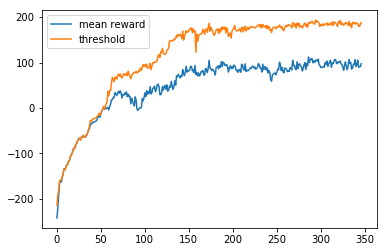

In [7]:
pl.plot(rewards, label='mean reward')
pl.plot(thresholds, label='threshold')
pl.legend()
pl.show()

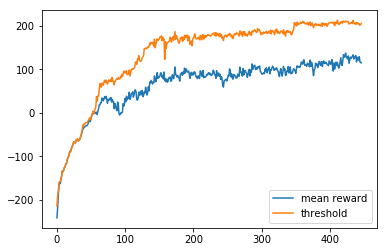

In [12]:
pl.plot(rewards, label='mean reward')
pl.plot(thresholds, label='threshold')
pl.legend()
pl.show()

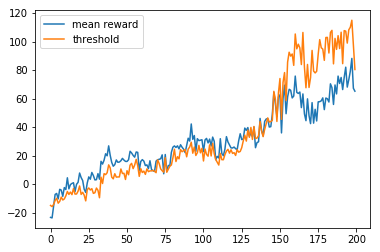

In [77]:
pl.plot(rewards, label='mean reward')
pl.plot(thresholds, label='threshold')
pl.legend()
pl.show()

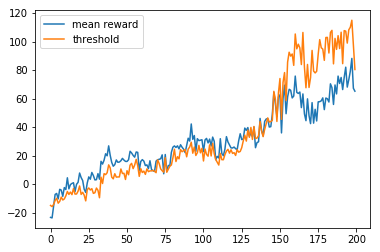

In [77]:
pl.plot(rewards, label='mean reward')
pl.plot(thresholds, label='threshold')
pl.legend()
pl.show()

In [13]:
env.close()